# InSituPy demonstration

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import scanpy as sc
import os
from insitupy import XeniumData

## Get example data for demonstration

How to download the example data for demonstration is shown [here](./00_InSituPy_demo_download_data.ipynb).

The final structure of the data should look like this:

    ```
    ./demo_dataset
    ├───output-XETG00000__slide_id__sample_id
    │   ├───analysis
    │   │   ├───clustering
    │   │   ├───diffexp
    │   │   ├───pca
    │   │   ├───tsne
    │   │   └───umap
    │   └───cell_feature_matrix
    └───unregistered_images
    ```


## Load Xenium data into `XeniumData` object

Now the Xenium data can be parsed by providing the data path to `XeniumData`

In [3]:
# prepare paths
out_dir = Path("demo_dataset") # output directory
data_dir = out_dir / "output-XETG00000__slide_id__sample_id" # directory of xenium data
image_dir = out_dir / "unregistered_images" # directory of images

In [4]:
xd = XeniumData(data_dir)

In [5]:
xd

XeniumData
Slide ID:	slide_id
Sample ID:	sample_id
Data path:	demo_dataset
Data folder:	output-XETG00000__slide_id__sample_id
Metadata file:	experiment.xenium

In [6]:
# read all data modalities at once
xd.read_all()

# alternatively, it is also possible to read each modality separately
# xd.read_matrix()
# xd.read_images()
# xd.read_boundaries()
# xd.read_transcripts()
# xd.read_annotations()

No `annotations` modality found.
Reading boundaries...
Reading images...
Reading matrix...
Reading transcripts...


Note: That the `annotations` modality is not found here is expected. Annotations are added in a later step.

### Register images automatically

Since _Xenium In Situ_ is a non-destructive method, it is possible to stain and image the tissue after the in situ sequencing analysis. However, this is done outside of the _Xenium_ machine and requires subsequent registration. `InSituPy` contains a automatic image registration pipeline based on the "Scale-invariant feature transform" (SIFT) algorithm ([publication](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94)).

Using the SIFT algorithm, common features between the template (_Xenium_ DAPI image) and the subsequently acquired images are detected and used to calculate a transformation matrix. This transformation matrix is then used to register the images to the template.

This example shows the result of SIFT with lines connecting the common features of two images:

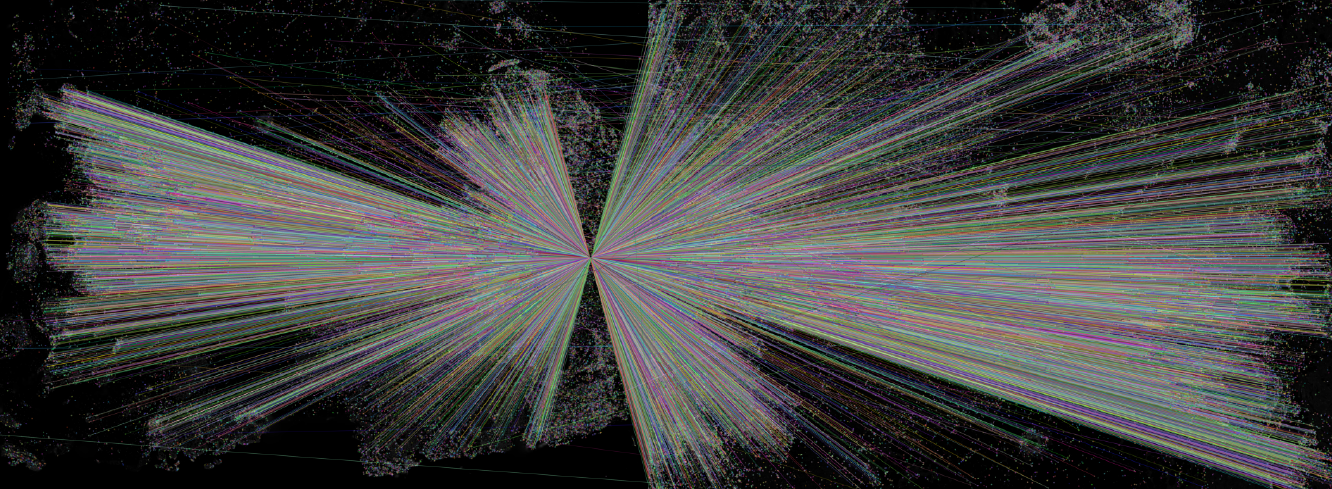*Common features extracted by SIFT algorithm*

Depending on the type of the images different preprocessing steps are necessary:
1. **Histological images** (H&E or IHC): These techniques result in an RGB image. To allow registration with the _Xenium_ DAPI image, color deconvolution is performed to extract the hematoxylin channel containing the nuclei.
2. **IF images**: Depending on the number of immunofluorescent stains, this method results in multiple grayscale images. For the method to work it is important that one of the channels contains signal from a nuclei stain (e.g. DAPI). For the registration, this channel is selected and used to detect common features with SIFT and calculate the transformation matrix. The other channels are then registered using the same transformation matrix.

#### Input files

The file naming of the images is very important for the algorithm to understand which images belong to which experiment. It is crucial to use following file naming: `{slide_id}__{sample_id}__{image_names}__{image_type}`

The images can be either in `.tif` or `.ome.tif` format and the suffix has to specified in `.register_images()`.

#### Output generated by the registration pipeline

1. **Registered images**: The registered images are saved as `.ome.tif` into a folder called `registered_images` in the parent directory of the folder containing the _Xenium_ data. The images files are named as follows: `slide_id__sample_id__name__registered.ome.tif`.
2. **Transformation matrix**: The transformation matrix is saved as `.csv` into a folder called `registration_qc` in the parent directory of the folder containing the _Xenium_ data. The file name ends with `__T.pdf`.
3. **Common features**: A representation of the common features between the registered image and the template is saved as well in the `registration_qc` folder as `.pdf` with the file name ending with `__common_features`.

```
    ./demo_dataset
    ├───output-XETG00000__slide_id__sample_id
    ├───registered_images
    │       slide_id__sample_id__name__registered.ome.tif <-- 1.
    ├───registration_qc
    │       slide_id__sample_id__name__T.csv <-- 2.
    │       slide_id__sample_id__name__common_features.pdf <-- 3.
    └───unregistered_images
```


In [7]:
xd.register_images(img_dir=image_dir, img_suffix=".tif")

Processing sample sample_id of slide slide_id
	Only unmodified metadata file (`experiment.xenium`) found. Information will be added to new file (`experiment_modified.xenium`).
	Processing following IF images: CD20, HER2, DAPI
		Loading images...
Reading images...
		Select image with nuclei from IF image (channel: 2)
		Load image into memory...
		Rescale image and template to save memory.
			Rescaled to following dimensions: (3314, 4827)
			Rescaled to following dimensions: (3412, 4688)
		Convert scaled images to 8 bit
		Extract common features from image and template
		2023-11-09 14:57:03: Get features...
			Method: SIFT...
		2023-11-09 14:57:08: Compute matches...
		2023-11-09 14:57:13: Filter matches...
			Sufficient number of good matches found (12491).
		2023-11-09 14:57:13: Display matches...
		2023-11-09 14:57:15: Fetch keypoints...
		2023-11-09 14:57:15: Estimate 2D affine transformation matrix...
		2023-11-09 14:57:15: Register image by affine transformation...
		Save OME-TIFF 

In [8]:
xd

XeniumData
Slide ID:	slide_id
Sample ID:	sample_id
Data path:	demo_dataset
Data folder:	output-XETG00000__slide_id__sample_id
Metadata file:	experiment.xenium
    ➤ images
       nuclei:	(25778, 35416)
    ➤ matrix
       AnnData object with n_obs × n_vars = 167780 × 313
	       obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
	       var: 'gene_ids', 'feature_types', 'genome'
	       obsm: 'spatial'
    ➤ transcripts
	   DataFrame with shape 42638083 x 8
    ➤ boundaries
       cells
       nuclei

To get access to the registered images, it is necessary to call `.read_images()` again.

In [9]:
xd.read_images()

Reading images...


In [10]:
xd

XeniumData
Slide ID:	slide_id
Sample ID:	sample_id
Data path:	demo_dataset
Data folder:	output-XETG00000__slide_id__sample_id
Metadata file:	experiment.xenium
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ matrix
       AnnData object with n_obs × n_vars = 167780 × 313
	       obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
	       var: 'gene_ids', 'feature_types', 'genome'
	       obsm: 'spatial'
    ➤ transcripts
	   DataFrame with shape 42638083 x 8
    ➤ boundaries
       cells
       nuclei

## Explore data in interactive `napari` viewer

Example image of the viewer:

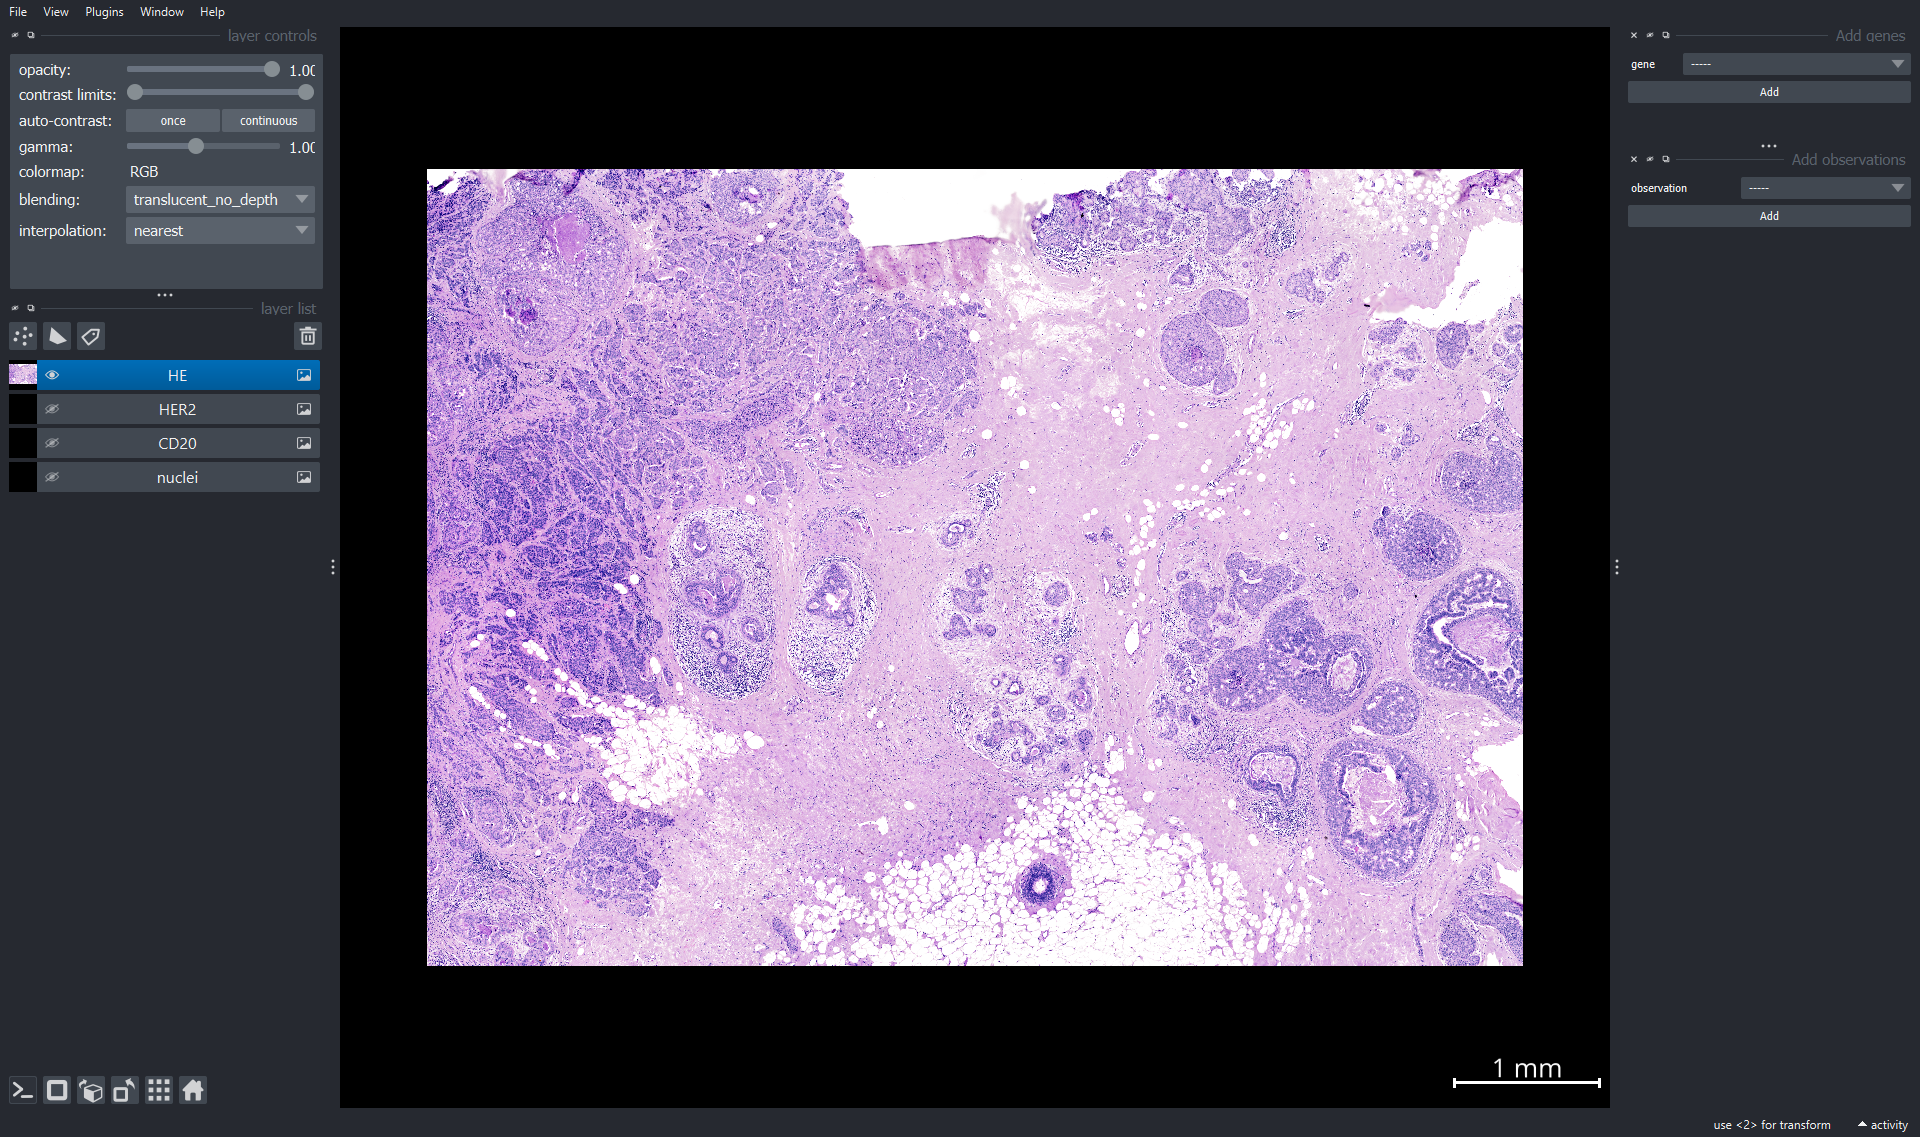

For detailed documentation on the functionalities of `napari` see: https://napari.org/stable/index.html

In [11]:
xd.show()

### Explore gene expression using `napari` viewer

Use the `"Add genes"` and `"Add observations"` widgets to explore the transcriptomic data.
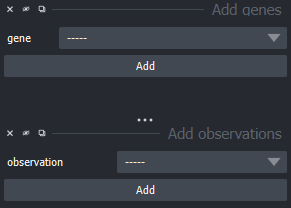

Genes can be selected from the dropdown window by scrolling or by clicking into the window and typing the name of the item:

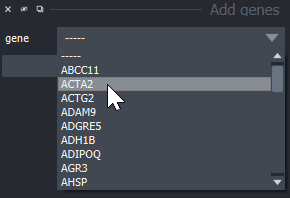

After selection of an item it can be added using the `"Add"` button. The data is added as point layer to the napari viewer.

### Crop data using the `napari` viewer

Steps for cropping:
1. Use the `"New shapes layer"` button to add a new layer of shapes: 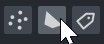
2. Use the `"Add rectangles"` button to select a rectangular region: 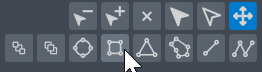
3. Rename the shapes layer or leave the default name `"Shapes"`.
4. Move back to Jupyter Notebook and run `xd.crop()`.

In [12]:
xd_cropped = xd.crop(shape_layer="Shapes")

# alternatively you can also crop using the xlim/ylim arguments
#xd.crop(xlim=(10000,11000), ylim=(12000,14000))

c:\Users\ge37voy\AppData\Local\miniconda3\envs\xparse\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [13]:
xd_cropped


XeniumData
Slide ID:	slide_id
Sample ID:	sample_id
Data path:	demo_dataset
Data folder:	output-XETG00000__slide_id__sample_id
Metadata file:	experiment.xenium
    ➤ images
       nuclei:	(8429, 12664)
       CD20:	(8429, 12664)
       HER2:	(8429, 12664)
       HE:	(8429, 12664, 3)
    ➤ matrix
       AnnData object with n_obs × n_vars = 20641 × 313
	       obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
	       var: 'gene_ids', 'feature_types', 'genome'
	       obsm: 'spatial'
    ➤ transcripts
	   DataFrame with shape 4954250 x 8
    ➤ boundaries
       cells
       nuclei

In [14]:
# show cropped data
xd_cropped.show()

## Perform preprocessing steps

`InSituPy` also includes basic preprocessing functions to normalize the transcriptomic data and perform dimensionality reduction. For normalization, the ``ScanPy`` function `sc.pp.normalize_total()` is used. Data transformation can be either done using logarithmic transformation or square root transformation as suggested [here](https://stlearn.readthedocs.io/en/latest/tutorials/Xenium_PSTS.html).


In [15]:
xd_cropped.normalize(transformation_method="sqrt")
xd_cropped.reduce_dimensions(umap=True, tsne=False)

Store raw counts in anndata.layers['counts']...
Normalization, log-transformation...
Dimensionality reduction...
Leiden clustering...


### Show results using `ScanPy` functions

c:\Users\ge37voy\AppData\Local\miniconda3\envs\xparse\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\ge37voy\AppData\Local\miniconda3\envs\xparse\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\ge37voy\AppData\Local\miniconda3\envs\xparse\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


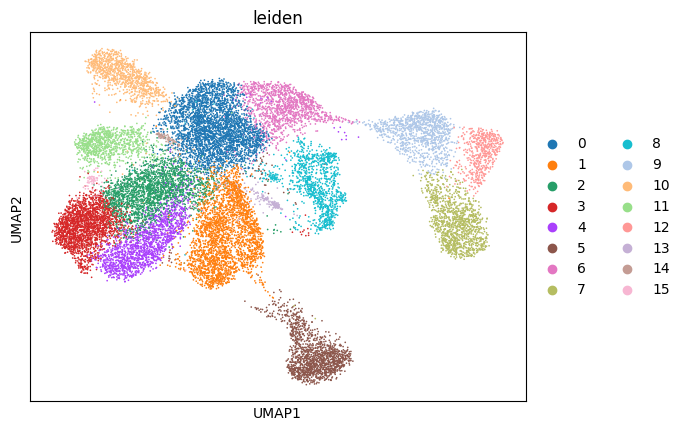

In [16]:
sc.pl.umap(xd_cropped.matrix, color="leiden")

Note: If the selected area contains more than 16 different leiden clusters, adding the leiden clusters results in following error:

```
ValidationError: 1 validation error for ColorManager
__root__
  Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe' (type=type_error)
```

This error seems to be intrinsic in `napari` and I already submitted an issue [here](https://github.com/napari/napari/issues/6433). I hope this gets solved soon.

In [17]:
# show cropped data
xd_cropped.show()

#### Start viewer with list of selected genes

Alternatively to selecting genes inside the napari viewer, it is also possible to open the viewer directly including a list of genes.

In [18]:
xd_cropped.show(keys=["leiden", "ACTA2", "LYZ", "LUM"])

Genes can be displayed or hidden via the eye symbol: <br>
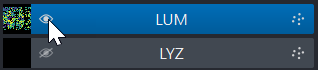

## Save results

The cropped and/or processed data can be saved into a folder using the `.save()` function of `XeniumData`.

The resulting folder has following structure:
```
cropped_processed
│   xenium.json
│   xeniumdata.json
│
├───boundaries
│       cells.parquet
│       nuclei.parquet
│
├───images
│       morphology_focus.ome.tif
│       slide_id__sample_id__CD20__registered.ome.tif
│       slide_id__sample_id__HER2__registered.ome.tif
│       slide_id__sample_id__HE__registered.ome.tif
│
├───matrix
│       matrix.h5ad
│
└───transcripts
        transcripts.parquet
```

In [19]:
out_dir = out_dir / "cropped_processed"
xd_cropped.save(out_dir, overwrite=True)

## Reload data

In [20]:
xd_reloaded = XeniumData(out_dir)

In [21]:
xd_reloaded.read_all()

No `annotations` modality found.
Reading boundaries...
Reading images...
Reading matrix...
Reading transcripts...


In [22]:
xd_reloaded

XeniumData
Slide ID:	slide_id
Sample ID:	sample_id
Data path:	demo_dataset
Data folder:	cropped_processed
Metadata file:	xeniumdata.json
    ➤ images
       nuclei:	(8429, 12664)
       CD20:	(8429, 12664)
       HER2:	(8429, 12664)
       HE:	(8429, 12664, 3)
    ➤ matrix
       AnnData object with n_obs × n_vars = 20641 × 313
	       obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'leiden'
	       var: 'gene_ids', 'feature_types', 'genome'
	       uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
	       obsm: 'X_pca', 'X_umap', 'spatial'
	       varm: 'PCs'
	       layers: 'counts', 'norm_counts'
	       obsp: 'connectivities', 'distances'
    ➤ transcripts
	   DataFrame with shape 4954250 x 8
    ➤ boundaries
       cells
       nuclei

In [23]:
xd_reloaded.show()